## Get Data

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('../input/train_set.csv')
val_df = pd.read_csv ('../input/val_set.csv')
test_df = pd.read_csv('../input/test_set.csv')

In [3]:
print(f'Train Set Shape: {train_df.shape}')
print(f'Validation Set Shape: {val_df.shape}')
print(f'Test Set Shape: {test_df.shape}')

Train Set Shape: (6000, 7)
Validation Set Shape: (1000, 7)
Test Set Shape: (1000, 7)


## Prepare FastText Embeddings

### Train a FastText Model on Data

In [4]:
from gensim.models import FastText

In [5]:
# Size of pretrained embedding
embedding_size = 100

# Word Limit for each input document
max_words = 100

In [6]:
train_sentences = train_df['News Text'].apply(lambda x: x.split()).to_list()

In [7]:
fasttext_model = FastText(sentences=train_sentences, vector_size=embedding_size, window=5, min_count=1, workers=4)

### Representing Each Article as a Vector

In [8]:
import numpy as np

In [9]:
def get_embedding(word):
    try:
        return fasttext_model.wv[word]
    except KeyError:  
        return np.zeros(embedding_size)

def get_article_tensor(article):
    words = article.split()
    word_embeddings = [get_embedding(word) for word in words[:max_words]] 
    
    if len(word_embeddings) < max_words:  # Pad if needed
        word_embeddings += [np.zeros(embedding_size)] * (max_words - len(word_embeddings))
    return np.array(word_embeddings)

In [10]:
# Get Feature Matrix
train_x_pt = np.array([get_article_tensor(article) for article in train_df['News Text']])

val_x_pt = np.array([get_article_tensor(article) for article in val_df['News Text']])

test_x_pt = np.array([get_article_tensor(article) for article in test_df['News Text']])

In [11]:
print(f'Train Features: {train_x_pt.shape}')
print(f'Validation Features Shape: {val_x_pt.shape}')
print(f'Test Features Shape: {test_x_pt.shape}')

Train Features: (6000, 100, 100)
Validation Features Shape: (1000, 100, 100)
Test Features Shape: (1000, 100, 100)


## Prepare Data for Learned Embeddings

### Tokenize and Create Padded Sequences

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
# Specify Size of Vocabulary
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size)  
tokenizer.fit_on_texts(train_df['News Text'])  

In [15]:
print (len(tokenizer.word_index))

54970


In [16]:
train_sequences = tokenizer.texts_to_sequences(train_df['News Text'])
val_sequences = tokenizer.texts_to_sequences(val_df['News Text'])
test_sequences = tokenizer.texts_to_sequences(test_df['News Text'])

In [17]:
# specify max size of document
max_length = 100
# pad sequences
train_x_le = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_x_le = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_x_le = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [18]:
print(f'Train Features: {train_x_le.shape}')
print(f'Validation Features Shape: {val_x_le.shape}')
print(f'Test Features Shape: {test_x_le.shape}')

Train Features: (6000, 100)
Validation Features Shape: (1000, 100)
Test Features Shape: (1000, 100)


## Get Label Data

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_df["Category"])
val_y = encoder.transform (val_df["Category"])
test_y = encoder.transform (test_df["Category"])

In [21]:
print(f'train_y shape: {train_y.shape}')
print(f'test_y shape: {val_y.shape}')
print(f'test_y shape: {test_y.shape}')

train_y shape: (6000,)
test_y shape: (1000,)
test_y shape: (1000,)


In [22]:
print(dict(enumerate(encoder.classes_)))

{0: 'Business & Economics', 1: 'Entertainment', 2: 'Science & Technology', 3: 'Sports'}


# Model Training

In [23]:
from keras.models import Model
from keras import layers

### Function to Plot Losses

In [24]:
import matplotlib.pyplot as plt

def plot_losses(history):
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(train_loss))
    
    # Plot
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")

    # Labels and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

### Early Stopping Callback

In [25]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

## Model 1

In [27]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(4)(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 8)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(4)(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_1 = Model([pt_input, le_input], output)

model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [44]:
history_1 = model_1.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=20, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - acc: 0.5511 - loss: 1.1021 - val_acc: 0.8640 - val_loss: 0.5290
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.8895 - loss: 0.4304 - val_acc: 0.9090 - val_loss: 0.3567
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9213 - loss: 0.3081 - val_acc: 0.9130 - val_loss: 0.3330
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9339 - loss: 0.2475 - val_acc: 0.9180 - val_loss: 0.2918
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9427 - loss: 0.2188 - val_acc: 0.9210 - val_loss: 0.2822
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9445 - loss: 0.2045 - val_acc: 0.9190 - val_loss: 0.2939
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9496 - loss: 0.1895 - val_acc: 0.9280 - val_loss: 0.2782
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9502 - loss: 0.1881 - val_acc: 0.9200 - val_loss: 0.3141
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

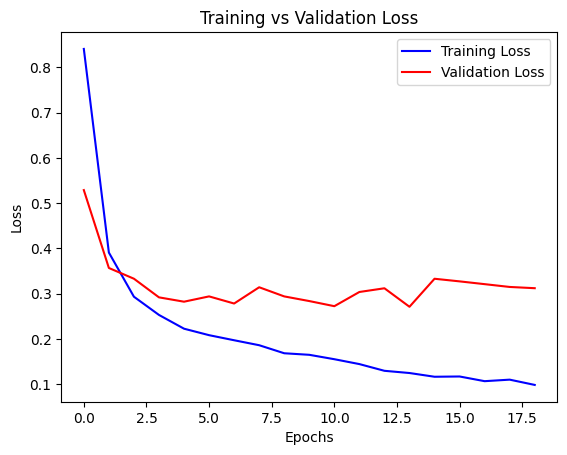

In [45]:
plot_losses(history_1)

### Conclusion: The best metrics reached for validation loss and accuracy are 0.2710 and 0.934 respectively. Previously, with an LSTM model of 4 nodes, the best metrics reached were 0.2867 and 0.923 using pretrained embeddings and 0.3106 and 0.927 using learned embeddings with embedding size of 8

## Model 2

### Increase nodes of first LSTM layer (taking as input pretrained embeddings) to 6

In [48]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(6)(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 8)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(4)(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_2 = Model([pt_input, le_input], output)

model_2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [49]:
history_2 = model_2.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=20, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - acc: 0.6796 - loss: 0.8937 - val_acc: 0.8940 - val_loss: 0.3712
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9020 - loss: 0.3416 - val_acc: 0.9110 - val_loss: 0.3048
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9291 - loss: 0.2416 - val_acc: 0.9220 - val_loss: 0.2676
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9446 - loss: 0.1969 - val_acc: 0.9210 - val_loss: 0.2556
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - acc: 0.9376 - loss: 0.2173 - val_acc: 0.9230 - val_loss: 0.2688
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9420 - loss: 0.1832 - val_acc: 0.9280 - val_loss: 0.2649
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9510 - loss: 0.1615 - val_acc: 0.9290 - val_loss: 0.2504
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9562 - loss: 0.1473 - val_acc: 0.9070 - val_loss: 0.3135
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

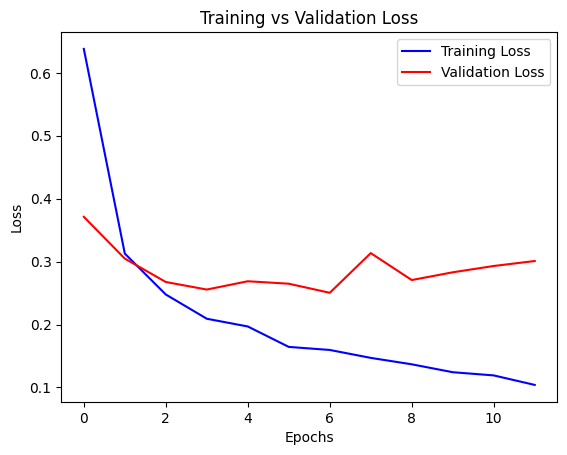

In [50]:
plot_losses(history_2)

### Conclusion: Increasing nodes for the LSTM layer suing pretrained embeddings to 6 has decreased loss from 0.270 to 0.2507. However, it has also decreaed accuracy slightly from 0.934 to 0.929

## Model 3

### Increase nodes of first LSTM layer (taking as input pretrained embeddings) to 8

In [51]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(8)(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 8)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(4)(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_3 = Model([pt_input, le_input], output)

model_3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [52]:
history_3 = model_3.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=20, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - acc: 0.6387 - loss: 0.9424 - val_acc: 0.9040 - val_loss: 0.3591
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9046 - loss: 0.3247 - val_acc: 0.9150 - val_loss: 0.3247
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9287 - loss: 0.2588 - val_acc: 0.9230 - val_loss: 0.2778
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9386 - loss: 0.2141 - val_acc: 0.9270 - val_loss: 0.2761
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9438 - loss: 0.2023 - val_acc: 0.9250 - val_loss: 0.2979
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9425 - loss: 0.1877 - val_acc: 0.9250 - val_loss: 0.2917
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9499 - loss: 0.1704 - val_acc: 0.9310 - val_loss: 0.2705
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - acc: 0.9556 - loss: 0.1604 - val_acc: 0.9310 - val_loss: 0.2602
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

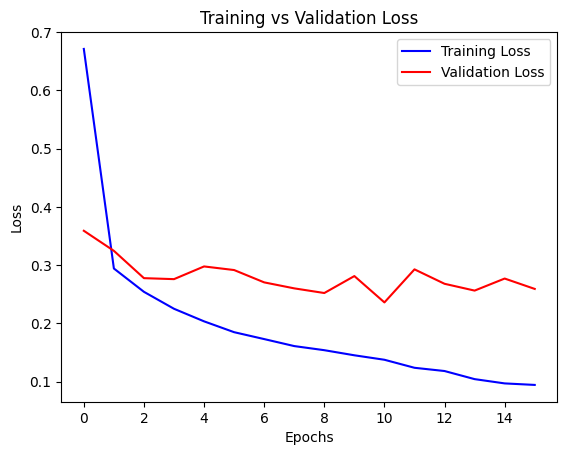

In [53]:
plot_losses(history_3)

### Increasing nodes (from 6 to 8) for the LSTM layer that takes as input pretrained embeddings has decreased loss from 0.2507 to 0.2361 while also increasing accuracy to 0.934

## Model 4

### Increase nodes of first LSTM layer (taking as input pretrained embeddings) to 12

In [54]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(12)(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 8)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(4)(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_4 = Model([pt_input, le_input], output)

model_4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [55]:
history_4 = model_4.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=20, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - acc: 0.7105 - loss: 0.8243 - val_acc: 0.9020 - val_loss: 0.3567
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9181 - loss: 0.3227 - val_acc: 0.9210 - val_loss: 0.2759
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9261 - loss: 0.2623 - val_acc: 0.9300 - val_loss: 0.2771
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9373 - loss: 0.2108 - val_acc: 0.9320 - val_loss: 0.2437
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9486 - loss: 0.1880 - val_acc: 0.9350 - val_loss: 0.2439
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9451 - loss: 0.1981 - val_acc: 0.9310 - val_loss: 0.2702
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9611 - loss: 0.1609 - val_acc: 0.9230 - val_loss: 0.3036
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9529 - loss: 0.1725 - val_acc: 0.9180 - val_loss: 0.3000
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

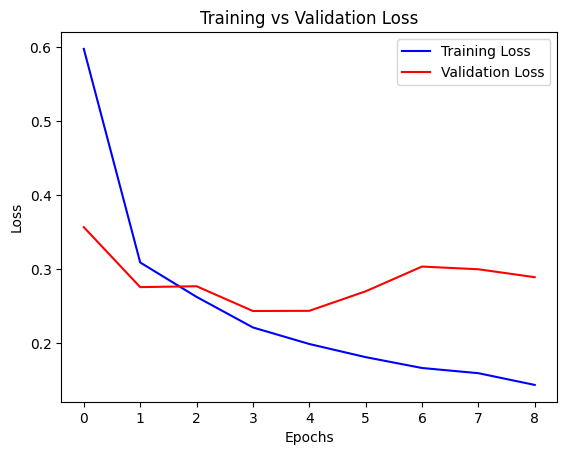

In [56]:
plot_losses(history_4)

### Increasing nodes (from 8 to 12) for the LSTM layer that takes as input pretrained embeddings slightly impairs performance

## Model 5

### Increase Nodes of Second LSTM layer from 4 to 8

In [59]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(8)(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 8)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(8)(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_5 = Model([pt_input, le_input], output)

model_5.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [60]:
history_5 = model_5.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=20, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - acc: 0.7048 - loss: 0.8964 - val_acc: 0.9120 - val_loss: 0.3128
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9179 - loss: 0.2977 - val_acc: 0.9180 - val_loss: 0.2946
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9321 - loss: 0.2511 - val_acc: 0.9300 - val_loss: 0.2432
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9334 - loss: 0.2314 - val_acc: 0.9200 - val_loss: 0.2836
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9503 - loss: 0.1933 - val_acc: 0.9210 - val_loss: 0.2937
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9497 - loss: 0.1917 - val_acc: 0.9240 - val_loss: 0.2859
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9584 - loss: 0.1669 - val_acc: 0.9160 - val_loss: 0.3100
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9585 - loss: 0.1665 - val_acc: 0.9190 - val_loss: 0.2881


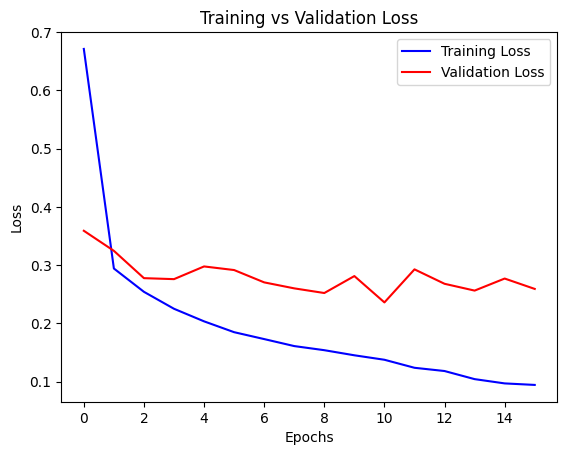

In [53]:
plot_losses(history_3)

### Increasing nodes (from 4 to 8) for the second LSTM layer that takes as input learned embeddings does not have a significant impact on performance (slight decrease)

## Model 6

### Increase Embedding of Size for Learned Embeddings from 8 to 16

In [65]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(8)(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 16)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(4)(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_6 = Model([pt_input, le_input], output)

model_6.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [66]:
history_6 = model_6.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=20, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - acc: 0.6818 - loss: 0.8625 - val_acc: 0.8910 - val_loss: 0.4021
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9041 - loss: 0.3503 - val_acc: 0.9110 - val_loss: 0.3120
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9193 - loss: 0.2679 - val_acc: 0.9220 - val_loss: 0.2779
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9308 - loss: 0.2320 - val_acc: 0.9270 - val_loss: 0.2630
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9443 - loss: 0.1991 - val_acc: 0.9320 - val_loss: 0.2674
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9391 - loss: 0.2046 - val_acc: 0.9300 - val_loss: 0.2506
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - acc: 0.9494 - loss: 0.1700 - val_acc: 0.9300 - val_loss: 0.2524
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9671 - loss: 0.1209 - val_acc: 0.9310 - val_loss: 0.2389
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

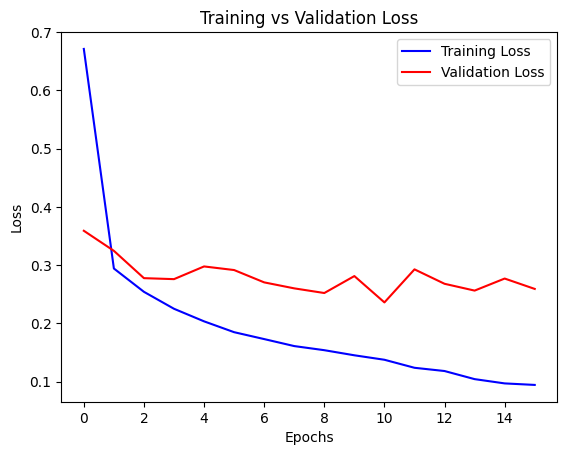

In [67]:
plot_losses(history_3)

### Increasing Embedding Size (from 8 to 16) for the second LSTM layer that takes as input learned embeddings does not have a impact on performance. Val loss = 0.2389, accuracy = 0.931

## Model 7

### Add Recurrent Dropout

In [56]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(8, dropout=0.1, recurrent_dropout=0.1)(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 16)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(4, dropout=0.1, recurrent_dropout=0.1)(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_7 = Model([pt_input, le_input], output)

model_7.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [57]:
history_7 = model_7.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=30, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - acc: 0.6461 - loss: 0.9243 - val_acc: 0.8760 - val_loss: 0.4214
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.8698 - loss: 0.4353 - val_acc: 0.9280 - val_loss: 0.3005
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.8977 - loss: 0.3588 - val_acc: 0.9220 - val_loss: 0.3128
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9121 - loss: 0.3151 - val_acc: 0.9300 - val_loss: 0.2916
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - acc: 0.9214 - loss: 0.2815 - val_acc: 0.9290 - val_loss: 0.2811
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - acc: 0.9244 - loss: 0.2465 - val_acc: 0.9290 - val_loss: 0.2895
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - acc: 0.9346 - loss: 0.2420 - val_acc: 0.9260 - val_loss: 0.2892
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - acc: 0.9368 - loss: 0.2275 - val_acc: 0.9270 - val_loss: 0.2740
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 

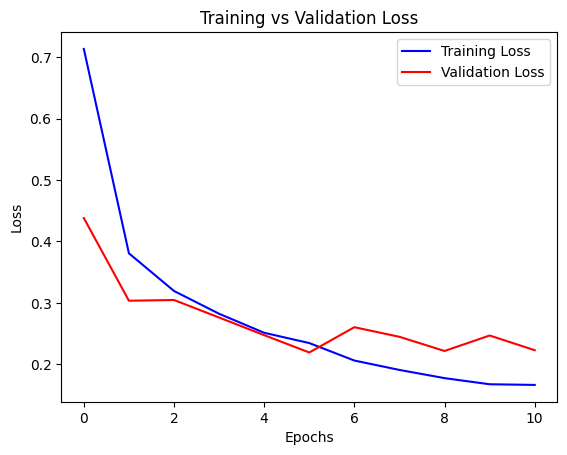

In [35]:
plot_losses(history_7)

## Model 8

### Increase Recurrent Dropout

In [28]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(8, recurrent_dropout=0.2)(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 16)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(4, dropout=0.2, recurrent_dropout=0.2)(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_8 = Model([pt_input, le_input], output)

model_8.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [29]:
history_8 = model_8.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=30, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - acc: 0.6674 - loss: 0.8808 - val_acc: 0.8890 - val_loss: 0.4508
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - acc: 0.8728 - loss: 0.4213 - val_acc: 0.9080 - val_loss: 0.3314
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9080 - loss: 0.3224 - val_acc: 0.9040 - val_loss: 0.3230
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9098 - loss: 0.3063 - val_acc: 0.9110 - val_loss: 0.3344
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - acc: 0.9096 - loss: 0.2918 - val_acc: 0.9230 - val_loss: 0.2859
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9202 - loss: 0.2701 - val_acc: 0.9230 - val_loss: 0.2776
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9250 - loss: 0.2430 - val_acc: 0.9220 - val_loss: 0.2711
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9268 - loss: 0.2546 - val_acc: 0.9280 - val_loss: 0.2743
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 

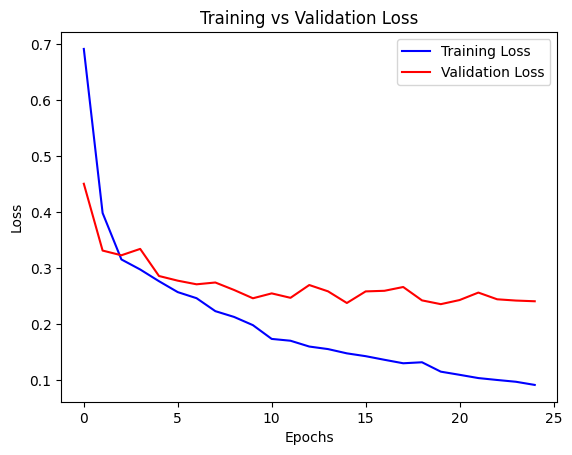

In [30]:
plot_losses(history_8)

### Increasing recurrent dropout rate and removing input dropout for the layer working on pretrained embeddings results in improved performance

## Model 9

### Add Regularisation

In [31]:
from keras.regularizers import l2

In [32]:
# Input channel for pretrained embeddings
pt_input = layers.Input(shape=(max_words, embedding_size))

# LSTM layer for pretrained embeddings
pt_lstm = layers.LSTM(8, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))(pt_input)

# Input for learned embeddings
le_input = layers.Input(shape=(None,))
# Embedding Layer
le_embedding = layers.Embedding(vocab_size, 16)(le_input)
# LSTM layer for learned embeddings
le_lstm = layers.LSTM(4, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))(le_embedding)

concatenated = layers.concatenate([pt_lstm, le_lstm], axis=-1)

output = layers.Dense(4, activation='sigmoid')(concatenated)

model_9 = Model([pt_input, le_input], output)

model_9.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [33]:
history_9 = model_9.fit(
    [train_x_pt, train_x_le], train_y,
    epochs=30, batch_size=8,
    validation_data=([val_x_pt, val_x_le], val_y),
    callbacks=early_stopping
)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - acc: 0.6527 - loss: 0.9700 - val_acc: 0.8980 - val_loss: 0.4256
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.8847 - loss: 0.4421 - val_acc: 0.9040 - val_loss: 0.3632
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - acc: 0.9050 - loss: 0.3482 - val_acc: 0.9210 - val_loss: 0.3311
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9100 - loss: 0.3476 - val_acc: 0.9200 - val_loss: 0.3202
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9182 - loss: 0.3023 - val_acc: 0.9220 - val_loss: 0.3177
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - acc: 0.9217 - loss: 0.3041 - val_acc: 0.9270 - val_loss: 0.2864
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - acc: 0.9196 - loss: 0.2810 - val_acc: 0.9210 - val_loss: 0.3016
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - acc: 0.9207 - loss: 0.2730 - val_acc: 0.9280 - val_loss: 0.3073
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 

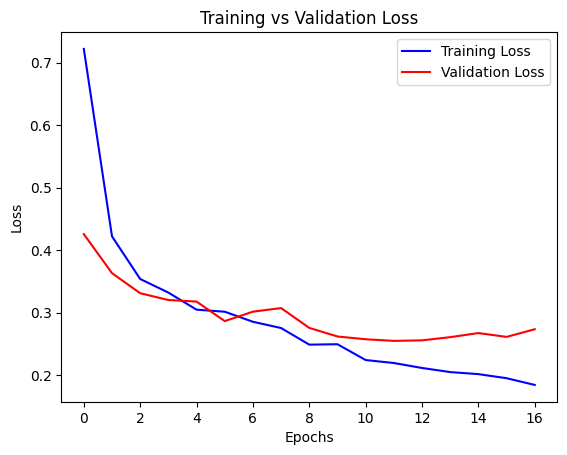

In [34]:
plot_losses(history_9)

### Adding regularisation increases validation loss and decreases accuracy

# Get Metrics on Test Set

In [35]:
from sklearn.metrics import classification_report, accuracy_score

In [39]:
y_pred = model_8.predict([test_x_pt, test_x_le])

# Get Label with highest probability
y_pred = y_pred.argmax(axis=1)  

# Generate classification report
report = classification_report(test_y, y_pred, digits=4)  
accuracy = accuracy_score(test_y, y_pred)  

print(report)
print(f"Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0     0.9225    0.9520    0.9370       250
           1     0.9325    0.8840    0.9076       250
           2     0.9331    0.9480    0.9405       250
           3     0.9602    0.9640    0.9621       250

    accuracy                         0.9370      1000
   macro avg     0.9371    0.9370    0.9368      1000
weighted avg     0.9371    0.9370    0.9368      1000

Accuracy: 0.9370
